In [1]:
import numpy as np
from skimage import io, color, filters, morphology, feature, transform
import math
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans


In [29]:
testcases = ['nothing1.png', 
             'nothing2.png',
			 'x1.png', 
			 'x2.png', 
			 'x3.png',
			 'x4.png',
			 'x5.png',
			 'o1.png', 
			 'o2.png',
             'o3.png',
			 'o4.png',
             'o5.png',	 
			 ]

In [15]:
def show_image(image, title=None):
    plt.imshow(image, cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [110]:
def draw_lines(hough_array, image, threshold_ratio=0.6):
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) if len(image.shape) == 2 else image.copy()
    h, w = hough_array.shape
    img_h, img_w = image.shape[:2]

    max_val = np.max(hough_array)
    threshold = max_val * threshold_ratio

    for r in range(h):
        for theta in range(w):
            if hough_array[r, theta] > threshold:
                angle = theta * np.pi / w
                radius = r - h // 2
                a = np.cos(angle)
                b = np.sin(angle)
                x0 = a * radius + img_w / 2
                y0 = b * radius + img_h / 2

                x1 = int(x0 + 1000 * (-b))
                y1 = int(y0 + 1000 * (a))
                x2 = int(x0 - 1000 * (-b))
                y2 = int(y0 - 1000 * (a))

                cv2.line(output, (x1, y1), (x2, y2), (0, 0, 255), 1)

    show_image(output, "Detected Lines")

In [19]:
def draw_circles(circles, image):
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) if len(image.shape) == 2 else image.copy()
    for x, y, r in circles:
        cv2.circle(output, (x, y), r, (0, 0, 255), 1)
    show_image(output, "Detected Circles")
    

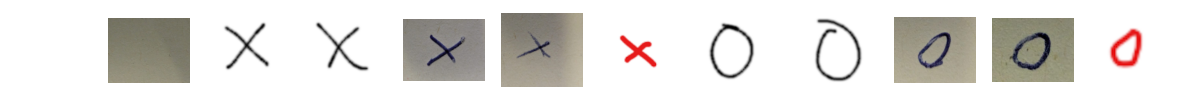

In [41]:
#function to showcase testcase images
def showcase_testcase_images(testcases):
    fig, axes = plt.subplots(1, len(testcases), figsize=(15, 5))
    for ax, testcase in zip(axes, testcases):
        img = io.imread(testcase)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()

showcase_testcase_images(testcases)

In [64]:
def suppress_if_flat(image, threshold=0.5):
    if image.max() - image.min() < threshold:
        return np.zeros_like(image)
    return image

In [62]:
def convert_to_binary(image):
    if image.shape[-1] == 4:
        image = color.rgba2rgb(image)
    gray_image = color.rgb2gray(image)  # Convert to grayscale
    gray_image = gray_image.astype(np.float32)  # Ensure float type for processing
    blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)  # Apply Gaussian blur
    inverted = 1 - blurred  # Invert the grayscale image
    inverted = suppress_if_flat(inverted)  # Suppress flat areas

    binary_image = inverted > np.max(inverted) * 0.6  
    binary_image_uint8 = (binary_image * 255).astype(np.uint8)
    return binary_image_uint8

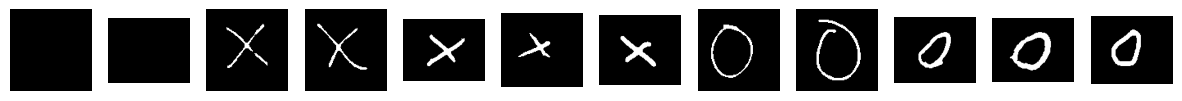

In [66]:
#function to showcase testcase images
def showcase_testcase_to_binary_images(testcases):
    fig, axes = plt.subplots(1, len(testcases), figsize=(15, 5))
    for ax, testcase in zip(axes, testcases):
        img = io.imread(testcase)
        binary_img = convert_to_binary(img)
        ax.imshow(binary_img, cmap='gray')
        ax.axis('off')
    plt.show()

showcase_testcase_to_binary_images(testcases)

In [12]:
def linearHT(im_edge, angle_steps, radius_steps):
    height, width = im_edge.shape

    xCtr = width // 2
    yCtr = height // 2
    nAng = angle_steps
    nRad = radius_steps
    dAng = np.pi / nAng
    rMax = int(np.sqrt((xCtr ** 2) + (yCtr ** 2)))
    dRad = 2 * rMax / nRad
    houghArray = np.zeros((nRad, nAng), dtype=np.int32)

    for v in range(height):
        for u in range(width):
            if im_edge[v, u] > 0:
                x = u - xCtr
                y = v - yCtr
                for i in range(nAng):
                    theta = i * dAng
                    r = int((x * np.cos(theta) + y * np.sin(theta)) / dRad) + nRad // 2
                    if 0 <= r < nRad:
                        houghArray[r, i] += 1

    return houghArray

In [14]:
def circleHT(I, radii_range):

    height, width = I.shape
    accumulator = np.zeros((height, width, len(radii_range)), dtype=np.uint64)

    # Edge points
    edge_points = np.argwhere(I)

    # For each edge point
    for y, x in edge_points:  # image coordinate (row, col) = (y, x)
        for r_idx, r in enumerate(radii_range):
            # Draw a circle centered at every possible (x, y) with radius r
            for theta in range(0, 360, 5):  # 5-degree steps
                a = int(x - r * np.cos(np.deg2rad(theta)))
                b = int(y - r * np.sin(np.deg2rad(theta)))
                if 0 <= a < width and 0 <= b < height:
                    accumulator[b, a, r_idx] += 1

    # Threshold: find local maxima in the accumulator
    threshold = np.max(accumulator) * 0.8  # You can tune this
    circles = []

    for y in range(height):
        for x in range(width):
            for r_idx, r in enumerate(radii_range):
                if accumulator[y, x, r_idx] > threshold:
                    circles.append((x, y, r))

    return circles

In [161]:
def is_possible_x(hough_array, angle_threshold_deg=15, prominence_ratio=0.9, spread_threshold=10, inertia_gap=0.5):
    """
    Accept only if there are 2 strong, compact angle clusters ~90° apart.
    Reject if the angles are scattered or noisy.
    """
    max_val = np.max(hough_array)
    if max_val == 0:
        return False

    height, width = hough_array.shape
    angle_step = 180.0 / width
    threshold = max_val * prominence_ratio

    angles = []
    for r in range(height):
        for theta in range(width):
            if hough_array[r, theta] >= threshold:
                angle_deg = (theta * angle_step) % 180
                angles.append(angle_deg)

    if len(angles) < 4:
        return False

    angles = np.array(angles).reshape(-1, 1)

    # Compare inertia for 1, 2, and 3 clusters
    inertia = []
    for k in [1, 2, 3, 4, 5]:
        kmeans = KMeans(n_clusters=k, n_init='auto', random_state=0).fit(angles)
        inertia.append(kmeans.inertia_)

    # Reject if 3 clusters are significantly better than 2 (i.e., image is messy)
    if len(inertia) >= 3 and inertia[1] - inertia[2] > inertia_gap * inertia[1]:
        if inertia[1] > 10000:
            print("Too much angle variety: 3 clusters explain better than 2.")
            return False
        print("Image is messy: 3 clusters explain better than 2 but further analysis needed.")

    # Now use 2 clusters and validate angle difference
    kmeans = KMeans(n_clusters=2, n_init='auto', random_state=0).fit(angles)
    centers = sorted(kmeans.cluster_centers_.flatten())
    labels = kmeans.labels_

    # Check if clusters are compact (low variance)
    std_devs = []
    for i in [0, 1]:
        cluster_angles = angles[labels == i].flatten()
        std = np.std(cluster_angles)
        std_devs.append(std)
        if std > spread_threshold:
            print(f"Cluster {i} is too spread out: std={std}")
            return False

    # Check angle difference is ~90°
    diff = abs(centers[1] - centers[0])
    diff = min(diff, 180 - diff)
    if abs(diff - 90) > angle_threshold_deg:
        print(f"Angle difference is not ~90°: {centers}")
        return False

    print(f"Valid X detected. Clusters: {centers}, std devs: {std_devs}")
    return True



In [128]:
def classify_cell(cell_img, angle_steps=180, radius_steps=100, radii_range=range(10, 20)):
    """
    Classifies a single tic-tac-toe cell as 'X', 'O', or 'Empty'.
    """

    hough_lines = linearHT(cell_img, angle_steps, radius_steps)
    #hough_lines = non_maximum_suppression(hough_lines, threshold=0.1)  # Apply non-maximum suppression
    hl_max = np.max(hough_lines)
    hough_lines = hough_lines > (hl_max * 0.5)  # Thresholding the Hough lines

    line_score = is_possible_x(hough_lines, angle_threshold_deg=20, prominence_ratio=0.9, spread_threshold=30, inertia_gap=0.5)

    # Apply custom Hough Circle detection
    circles = circleHT(cell_img, radii_range)
    circle_score = len(circles)
    print(f"Line Score: {line_score}, Circle Score: {circle_score}")
    # Decision logic
    if line_score == True :
        return 'X'
    elif circle_score >= 2 and line_score == False:
        return 'O'
    else:
        return 'Empty'

In [151]:
#for testing purposes: Take image, make it binary, dilate it and then classify it
def classify_testcase_image(testcase):
    image = io.imread(testcase)
    binary_image = convert_to_binary(image)
    classification = classify_cell(binary_image, angle_steps=180, radius_steps=100, radii_range=range(10, 20))
    return classification

for testcase in testcases:
    classification = classify_testcase_image(testcase)
    print(f"Testcase {testcase}: {classification}")



Line Score: False, Circle Score: 0
Testcase nothing1.png: Empty
Line Score: False, Circle Score: 0
Testcase nothing2.png: Empty
Inertia values for 1-5 clusters: [100609.87234042553, 1132.4130434782608, 715.1842105263158, 354.96992481203006, 207.15643274853804]
Valid X detected. Clusters: [np.float64(40.21739130434784), np.float64(132.25)], std devs: [np.float64(4.960334155461447), np.float64(4.8584119490494695)]
Line Score: True, Circle Score: 46
Testcase x1.png: X
Inertia values for 1-5 clusters: [76273.67567567568, 729.7460317460319, 372.60317460317475, 185.71428571428572, 102.33766233766234]
Valid X detected. Clusters: [np.float64(32.1111111111111), np.float64(137.42857142857142)], std devs: [np.float64(4.229391812310704), np.float64(5.043024763515652)]
Line Score: True, Circle Score: 43
Testcase x2.png: X
Inertia values for 1-5 clusters: [101847.91044776121, 3165.277777777778, 2499.777777777778, 1040.9495798319326, 570.525]
Valid X detected. Clusters: [np.float64(55.777777777777786

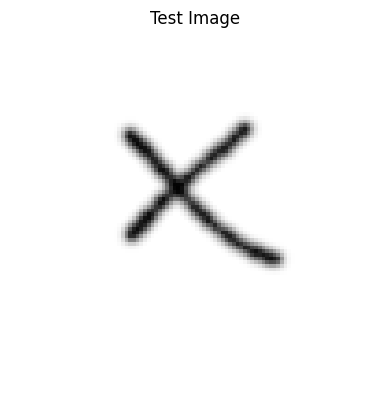

Image is messy: 3 clusters explain better than 2 but further analysis needed.
Valid X detected. Clusters: [np.float64(48.3809523809524), np.float64(132.36363636363637)], std devs: [np.float64(9.883620309037733), np.float64(4.088033529778048)]
Line Score: True, Circle Score: 37
Testcase test.png: X


In [176]:
image_name = 'test.png'
image_display = io.imread(image_name)
show_image(image_display, title="Test Image")
classification = classify_testcase_image(image_name)
print(f"Testcase {image_name}: {classification}")